## Processing the data before training the models



In [ ]:
!pip install -q imbalanced-learn
!pip install -q shap

     |████████████████████████████████| 358kB 15.5MB/s 


In [ ]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [ ]:
PATH = "/content/drive/MyDrive/MoneyLionDataset/processed.csv"

In [ ]:
df = pd.read_csv(PATH, index_col=[0]).drop("index", axis=1)

Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
df.head(10)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,isCollection,total_amount_paid,remainder_to_pay,days_to_process_loan,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription,.underwritingdatacl

## Remove certain columns


I will be removing some of the columns which are not needed. 

1. *applicationDate* and *originatedDate* are both used to derive *days_to_process_loan* 
2. *approved* and *isFunded* are both used to filter the loans beforehand and have a single common value. 
3. *clarityFraudId*, *loanId*, *underwritingid*  are all unique identifiers of the loans. 
4. Removed *clearfraudscore* as I have already converted it to *clearFraudScoreGroup*. 

In [ ]:
remove_cols = ['anon_ssn', 'clearfraudscore', 'applicationDate', 'originatedDate', 'approved', 'isFunded', 'clarityFraudId', 'loanId', 'hasCF', 'underwritingid', 'originated']
df.drop(columns=remove_cols, axis=1, inplace=True)

In [ ]:
# Replace boolean values with int values
df.replace({False: 0, True: 1}, inplace=True)

In [ ]:
df.head(10)

,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,target,isCollection,total_amount_paid,remainder_to_pay,days_to_process_loan,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarit

## Impute missing values

Looking at the % of missing values in each column I can see that most have minimal missing values while some of the columns added in from the *clarity.csv* have very high missing values. 

For numerical columns I will impute the missing values with the median value as the median is less impacted by outliers compared to mean where there are many outliers in the numerical columns. 

For categorical columns I will impute the missing category by labelling the missing value as "Missing". 

For any column with 80% and above missing value I will drop it. 

In [ ]:
missing_percentage_df = df.isnull().sum() * 100/len(df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_percentage_df)

payFrequency                                                                                            0.000000
apr                                                                                                     0.000000
nPaidOff                                                                                                0.010125
loanStatus                                                                                              0.000000
loanAmount                                                                                              0.000000
originallyScheduledPaymentAmount                                                                        0.000000
state                                                                                                   0.000000
leadType                                                                                                0.000000
leadCost                                                                                        

In [ ]:
def get_features(df):
  """
  Takes as input the dataframe and then returns 
  the categorical, numerical and temporal variables 
  in the dataframe
  in the form of a list
  """
  cat_feat = [num for num in df.columns if df[num].dtypes == "O" or df[num].dtypes == "bool"]
  numeric_feat = [num for num in df.columns if df[num].dtypes != "O"]
  temp_variables = [num for num in df.columns if df[num].dtype == "datetime64[ns]"]
  return cat_feat, numeric_feat, temp_variables

In [ ]:
categorical_cols, numerical_cols, _ = get_features(df)

In [ ]:
# Remove columns with 80%+ missing values 
df = df.loc[:, df.isnull().mean() < .8]

In [ ]:
df.head(10)

,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,target,isCollection,total_amount_paid,remainder_to_pay,days_to_process_loan,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearFraudScoreGroup,loan_per_ssn
0,B,199.0,0.0,Paid Off

In [ ]:
# Columns that should not be standardized
col = ['isCollection', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict', '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk', '.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother', '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious','.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential', '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate', '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile', '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified', '.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother', '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased', '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly', '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18', '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate', '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone', '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone', 'target', '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile']

In [ ]:
numerical_cols_ = [column for column in numerical_cols if column not in col]
pprint(numerical_cols_)

['apr',
 'nPaidOff',
 'loanAmount',
 'originallyScheduledPaymentAmount',
 'leadCost',
 'total_amount_paid',
 'remainder_to_pay',
 'days_to_process_loan',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago',
 '.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators',
 '.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount',
 '.und

In [ ]:
# Fill missing values in numerical column with median 
for cols in numerical_cols_:     
    df[cols].fillna(df[cols].median(),inplace=True)

In [ ]:
# Filter out the cols that are not considered for filling missing values
categorical_columns, _, _ = get_features(df)
cat_cols = categorical_columns + col
categorical_columns_ = [cols for cols in cat_cols if cols not in ['.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile', 'target']]
pprint(categorical_columns_)

['payFrequency',
 'loanStatus',
 'state',
 'leadType',
 'fpStatus',
 '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch',
 '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch',
 '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype',
 '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult',
 '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription',
 '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult',
 '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch',
 'clearFraudScoreGroup',
 'isCollection',
 '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict',
 '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress',
 '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthan

In [ ]:
# Fill missing categories with "Missing"
df[categorical_columns_] = df[categorical_columns_].fillna("Missing")

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.sample(10)

,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,target,isCollection,total_amount_paid,remainder_to_pay,days_to_process_loan,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearFraudScoreGroup,loan_per_ssn
871,W,416.50,1.0,Paid 

## Standarizing the numerical columns 

I will be standarizing the numerical columns using RobustScaler to avoid attributes with greater numeric ranges dominating those in smaller numeric ranges. 

In [ ]:
_, numerical_features, _ = get_features(df)

In [ ]:
pprint(numerical_features)

['apr',
 'nPaidOff',
 'loanAmount',
 'originallyScheduledPaymentAmount',
 'leadCost',
 'target',
 'total_amount_paid',
 'remainder_to_pay',
 'days_to_process_loan',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago',
 '.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago',
 '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict',
 '.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindica

In [ ]:
# Filter out the target column
num_feats = [feat for feat in numerical_features if feat not in ['target']]

In [ ]:
scaler = RobustScaler()
df[num_feats] = scaler.fit_transform(df[num_feats])

## One-hot-encode categorical features

Next I will transform the categorical features to one-hot-encoded vectors as the model can only take in numeric input. I could instead assign values for each unique category in a feature but that assumes that the categories are ordinal. 

In [ ]:
max_number_of_categories = max([df[cat].nunique() for cat in categorical_columns_])
print(f"Max number of categories in categorical features: {max_number_of_categories}")

Max number of categories in categorical features: 39


In [ ]:
df = pd.get_dummies(df, columns=categorical_columns_)

In [ ]:
df.head(10)

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,target,total_amount_paid,remainder_to_pay,days_to_process_loan,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch_match,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch_mismatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch_partial,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch_unavailable,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_A,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_F,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_FA,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_L,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_LA,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_M,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_Missing,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_P,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype_U,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult_invalid,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult_match,.underwritingd

Downside of using one-hot-encoding is that the columns are now sparse if columns had more unique categories than it would be best to use embeddings instead to reduce the sparsity. 

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Training the model 

I will try training with a simple Logistic Regression(LR) model initially and based on its performance try other models. 

Information about modelling details:
1. Hyperparameter optimization: GridSearchCV
2. Performance metric: F1 score 
3. Stratified k-fold is used as it keeps the ratio of the labels in each fold constant. 
4. SMOTE oversamples the minority class to ensure the model does not have poor performance on the minority class. 
5. Plotting confusion matrix to check that both false positive and false negatives are indeed low.





In [ ]:
X = df.loc[:, ~df.columns.isin(['target'])]
y = df[['target']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.values.ravel(),
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

scoring = ['f1', 'roc_auc']

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=42)

In [ ]:
pipeline = imbpipeline(steps = [['classifier', LogisticRegression(random_state=42,max_iter=1000)]])


    
param_grid = {'classifier__penalty': ['l1','l2'], 'classifier__C': [100, 10, 1.0, 0.1, 0.01]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=stratified_kfold,
                           refit='f1',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.9999255675474507
Test score: 0.9998264190244749


In [ ]:
y_pred = grid_search.predict(X_test)
cm_gd = confusion_matrix(y_test, y_pred)

In [ ]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],['classifier', LogisticRegression(random_state=42,max_iter=1000)]])
    
param_grid = {'classifier__penalty': ['l1','l2'], 'classifier__C': [100, 10, 1.0, 0.1, 0.01]}
grid_search_ = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=stratified_kfold,
                           refit='f1',
                           n_jobs=-1)

grid_search_.fit(X_train, y_train)
cv_score = grid_search_.best_score_
test_score = grid_search_.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


Cross-validation score: 0.9999255675474507
Test score: 0.9998264190244749


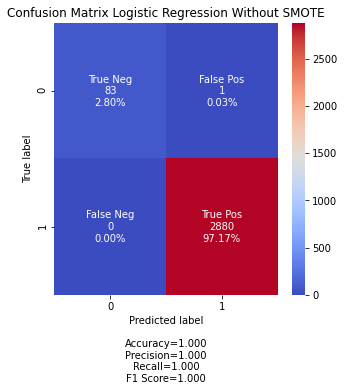

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm_gd, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm',
                      figsize=(5,5),
                      title="Confusion Matrix Logistic Regression Without SMOTE")

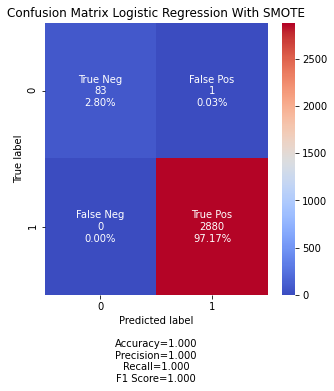

In [ ]:
y_pred_ = grid_search.predict(X_test)
cm_gd_ = confusion_matrix(y_test, y_pred_)


make_confusion_matrix(cm_gd_, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm',
                      figsize=(5,5),
                      title="Confusion Matrix Logistic Regression With SMOTE")

Looking at the confusion matrix and the results of both models we can see that the model achieves the main objective of minimizing the false positives and false negatives but with perfect results that would indicate that the model is not generalizable to real data. Its not a case of underfitting or overfitting but probably a case of data-leakage happening. 

In this case more data definitely needs to be included in the training of the model as currently there are only 10K rows of data which are extremely imbalanced. 

I could try to train a model using gradient boosting method or neural networks but the results would probably be the same as the logistic regression model but the results would be the same. 


## Feature Importance using SHAP

I will be taking a sample of the data and plotting the continous features that were added in through feature engineering.

Permutation explainer: 9878it [43:38,  3.77it/s]


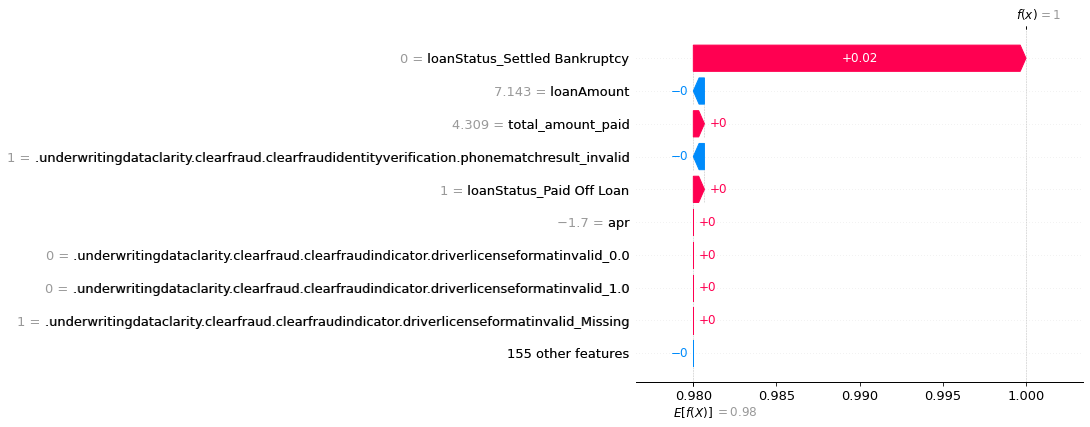

In [ ]:
model = grid_search.best_estimator_
explainer = shap.Explainer(model.predict, X_train) 
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

The waterfall shows the features that were most important for a single example in the dataset and in this case it shows that having a loanStatus of Settleed Bankruptcy is the most influential feature but this is not the case for the rest of the dataset just this one example. 

The plots below look at how the changes in some variables impact as those the values of those variables changes over the dataset. 

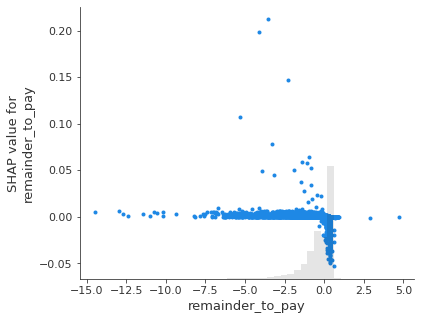

In [ ]:
shap.plots.scatter(shap_values[:,"remainder_to_pay"])

Most of the values in *remainder_to_pay* have no impact except when the standardised values are centered around 0 which have a negative impact on the loan being paid off. 

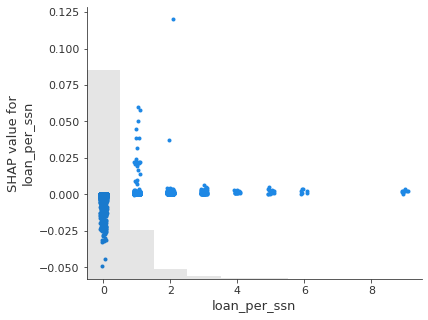

In [ ]:
shap.plots.scatter(shap_values[:,"loan_per_ssn"])

When the *loan_per_ssn* is 0, it is a negative predictor of whether a loan will be paid off whereas loan values of 1 are a positive predictor of a loan being paid off. 

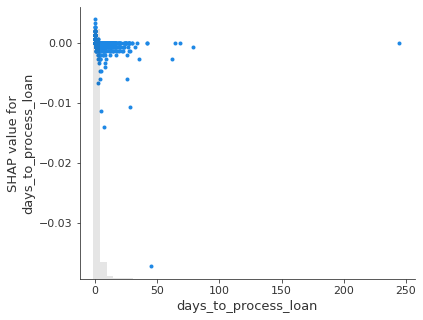

In [ ]:
shap.plots.scatter(shap_values[:,"days_to_process_loan"])

I can't make a proper evaluation of this plot. 

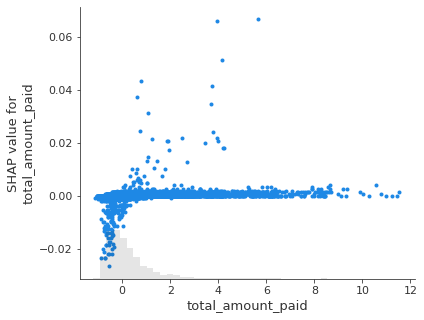

In [ ]:
shap.plots.scatter(shap_values[:,"total_amount_paid"])

Smaller standardised amounts for *total_amount_paid* are negative predictors of whether a loan will be paid off.

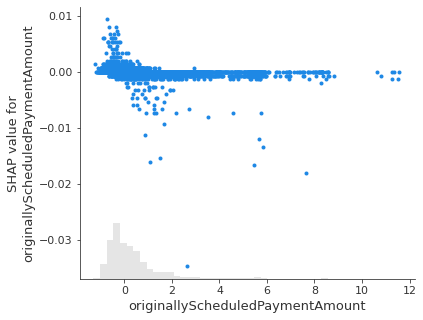

In [ ]:
shap.plots.scatter(shap_values[:,"originallyScheduledPaymentAmount"])

Smaller *originallyScheduledPaymentAmounts* are positive predictors of a loan being paid off. 

## Conclusion:

1. More effort needs to be done on feature engineering on all three datasets in order to extract more meaningful predictions
2. There needs to be more samples of defaulted loans to lessen the impact of imbalanced predictions. Currently at 3% defaulted cases it is very difficult to say whether the current model would actually make proper predictions on real world data. 
3. Feature importance plots using SHAP are difficult to interpret with such imbalanced data. 
4. More features regarding customer debt to income ratio, customer credit score, etc. could help with modelling. 
5. With more examples, models that deal with missing values would be better suited such as gradient boosting with decision trees. 

